# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

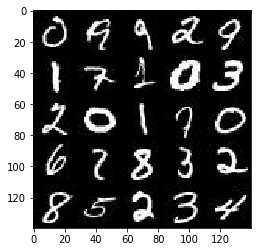

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

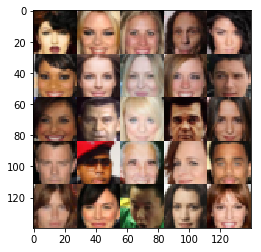

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [27]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    '''
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    '''
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)) 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, [])
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [28]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
            
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)


    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # Tell TensorFlow to update the population statistics while training
    # See https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Solutions.ipynb
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_shape = data_shape[1:]    
    input_real, input_z, lr_rate = model_inputs(*image_shape, z_dim)
    out_channel_dim = image_shape[-1]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    n_images = 25
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Sample random noise for G
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 # turn(-0.5, 0.5) into (-1, 1) for Tanh activation functions.
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})

                # Output losses for every 10 batches
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Output generated images for every 100 batches
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.4648... Generator Loss: 14.5023
Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 4.3455
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 3.4483
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 3.0734
Epoch 1/2... Discriminator Loss: 0.4019... Generator Loss: 4.1507
Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 3.2155
Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 5.9070
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 2.7592
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 3.3201
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.7400


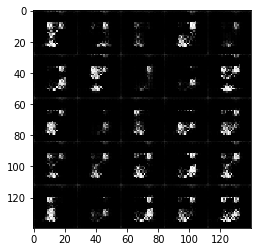

Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 2.1591
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.4284
Epoch 1/2... Discriminator Loss: 5.7264... Generator Loss: 9.0323
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.4867
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 4.7004
Epoch 1/2... Discriminator Loss: 0.6654... Generator Loss: 1.8264
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 4.0052


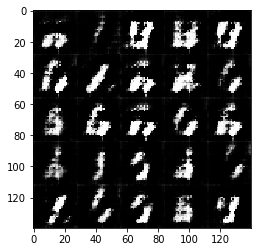

Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.8706
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 1.8650
Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 3.9483
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 4.3024
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 1.9787
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 3.4702
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.5397
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 2.2021
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.2596


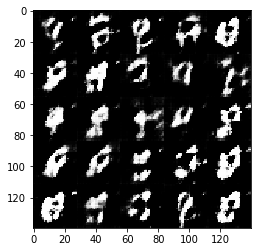

Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 3.2364
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 2.7926
Epoch 1/2... Discriminator Loss: 1.7157... Generator Loss: 0.4754
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 2.5746
Epoch 1/2... Discriminator Loss: 2.5385... Generator Loss: 4.9521
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.5514


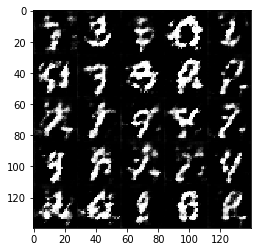

Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.6390
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.1921
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.8904


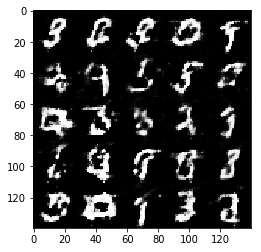

Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 2.7000
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.6464
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 1.8102
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.4328
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.7114
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.6651


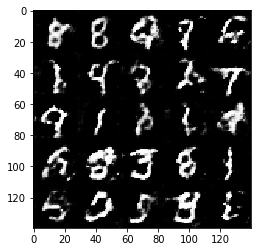

Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 2.3244
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 2.2548
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 2.5148
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.6473
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 2.1518
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 2.6890
Epoch 1/2... Discriminator Loss: 1.5516... Generator Loss: 3.2382


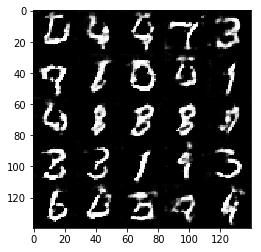

Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.6883
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.5914
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 2.5967
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.6231
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.6524


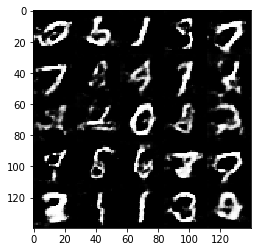

Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.5013
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 1.2955
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 1.0222
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 1.4666
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 1.8964
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.6872


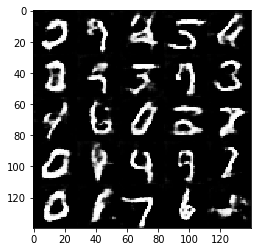

Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 2.8026
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.5791
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 1.4849
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 2.1130
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 1.2006


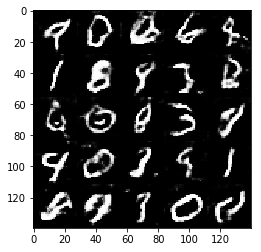

Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 2.4086
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.7780
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.9344


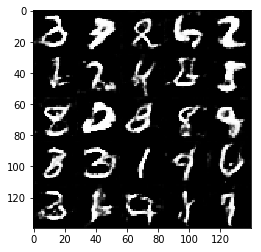

Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.9462
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.0355
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 2.0200
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 2.3669... Generator Loss: 4.0390
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.6063


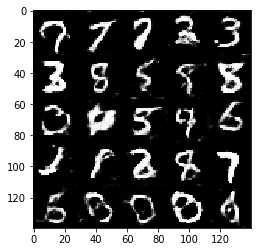

Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.9878
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 1.7251
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 2.1751
Epoch 2/2... Discriminator Loss: 1.6838... Generator Loss: 2.4138
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 1.6306
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.5055
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.3432
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.1687


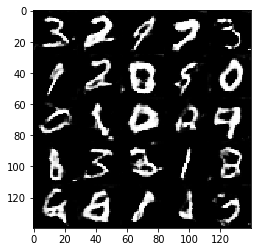

Epoch 2/2... Discriminator Loss: 2.5480... Generator Loss: 3.6500
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 1.6103
Epoch 2/2... Discriminator Loss: 1.6709... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 1.9929
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 2.5874
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.6327... Generator Loss: 0.4355


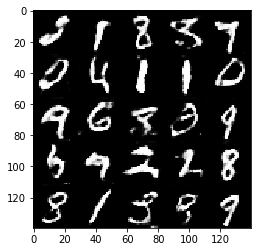

Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.3653
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 1.5817
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.1915


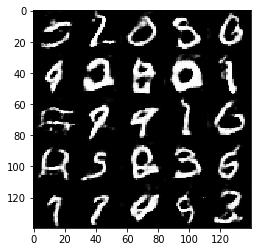

Epoch 2/2... Discriminator Loss: 1.5793... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.2393
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.3682
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 3.0673
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 2.0274
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.6607
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.5012


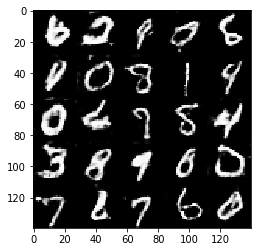

Epoch 2/2... Discriminator Loss: 1.5491... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 1.8187
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.1293
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 2.0519
Epoch 2/2... Discriminator Loss: 1.8739... Generator Loss: 3.1347
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.3355


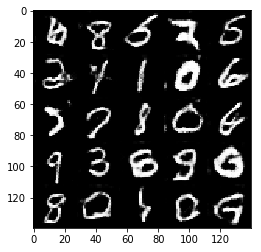

Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 1.7103
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.7370
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 1.4913
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 2.1699
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.5865
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 1.8411... Generator Loss: 2.8055
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.9426


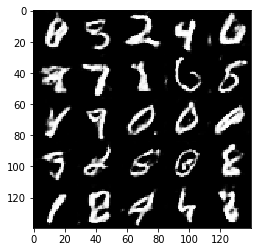

Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 1.0238
Epoch 2/2... Discriminator Loss: 1.6702... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 2.1592
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 2.1867
Epoch 2/2... Discriminator Loss: 0.6298... Generator Loss: 2.7417
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.9814


In [53]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 4.9666
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 7.5267
Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.6244
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 2.6844... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 2.9419
Epoch 1/1... Discriminator Loss: 2.2608... Generator Loss: 0.2593
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.7027


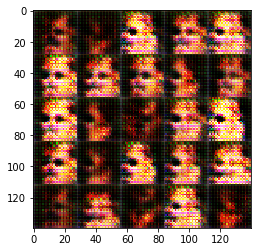

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 5.2139
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 5.2913
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 3.1470
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.7322
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.7522
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 4.8485
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.5972


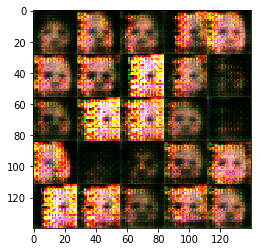

Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.3268
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 2.9189
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 2.6469
Epoch 1/1... Discriminator Loss: 3.1994... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 2.8451
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.4719


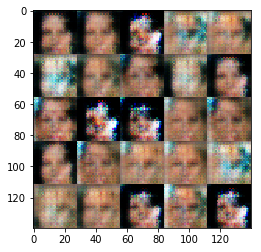

Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 2.0123... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.5965
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.1975


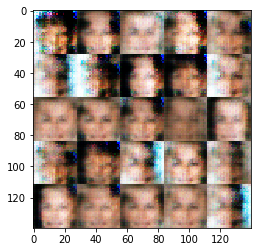

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 2.0107
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.7836... Generator Loss: 2.5854
Epoch 1/1... Discriminator Loss: 2.0318... Generator Loss: 0.2290
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 2.5535
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.7839... Generator Loss: 0.3344


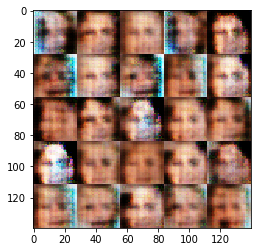

Epoch 1/1... Discriminator Loss: 2.5223... Generator Loss: 0.1507
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 1.7314
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 2.5502
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.4777


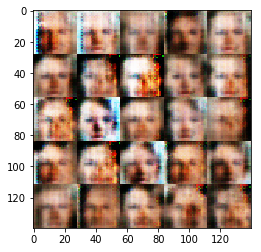

Epoch 1/1... Discriminator Loss: 3.0854... Generator Loss: 4.2207
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 2.8229
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.5040


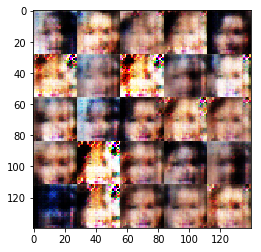

Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6703


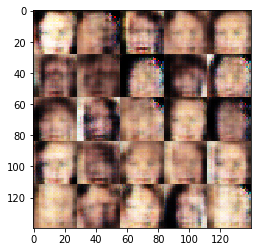

Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.3507
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.4938
Epoch 1/1... Discriminator Loss: 1.9202... Generator Loss: 0.3484


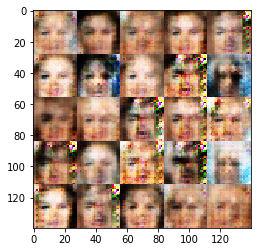

Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.6063
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.8140


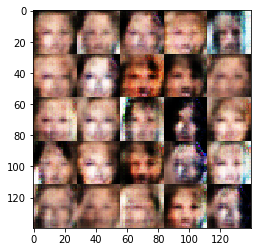

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.7446... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 2.5484
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.7071


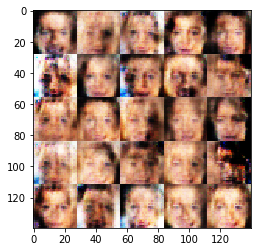

Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9653


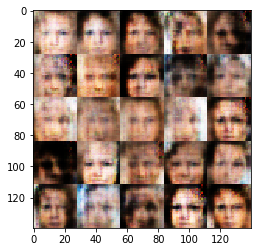

Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.5546
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8977


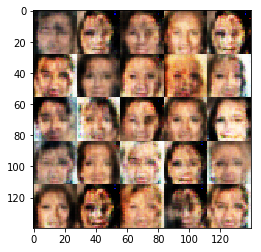

Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.8900
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.8426
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5029


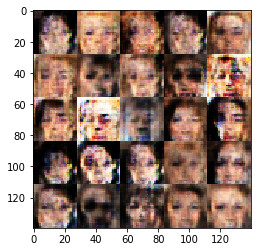

Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.7037
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.8630
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.4453


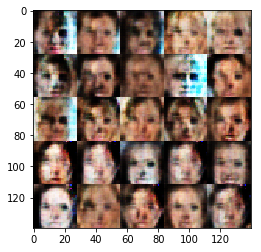

Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.3495
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 2.4103
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7494


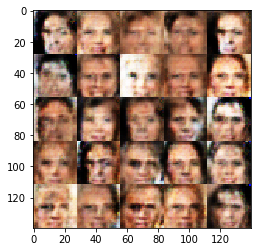

Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.8381
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 2.4841
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 2.8630
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.1762


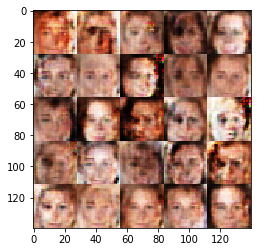

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 2.7839
Epoch 1/1... Discriminator Loss: 2.1588... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.6805
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 2.7390
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.3801


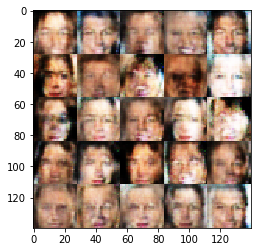

Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.4114
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 2.7502
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 2.5002
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.8144


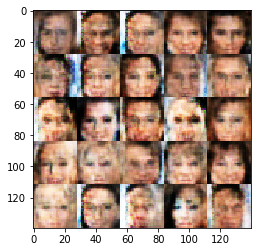

Epoch 1/1... Discriminator Loss: 1.8189... Generator Loss: 4.3862
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 2.2819
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 3.0736
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 2.4681


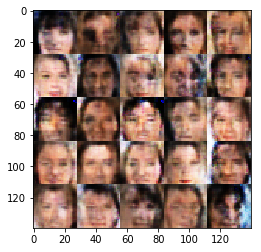

Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 2.6888... Generator Loss: 4.3383
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 2.0683
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.8076
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.4337
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.4106


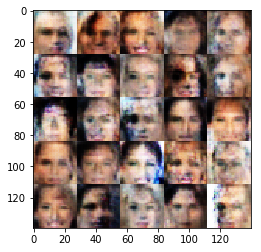

Epoch 1/1... Discriminator Loss: 1.8819... Generator Loss: 0.3181
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 2.8183
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 3.2615
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.9517
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 2.0282
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9928


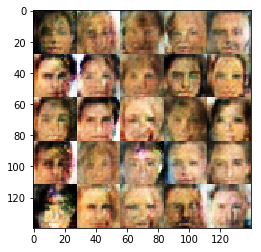

Epoch 1/1... Discriminator Loss: 2.3784... Generator Loss: 3.1646
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 2.3954
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.9061... Generator Loss: 0.3251


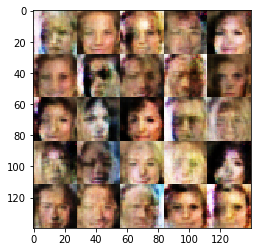

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.9235
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 1.8316
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.9291
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 2.2225
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.9994
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 2.2221


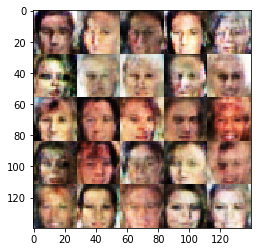

Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.8744... Generator Loss: 2.1770
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 2.3107
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.9764
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 2.1544


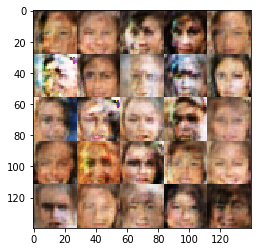

Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.8391
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9882


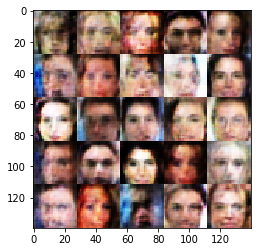

Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.1342


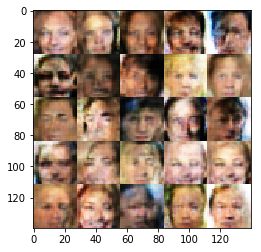

Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 2.3356... Generator Loss: 0.2094
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 2.1178
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 2.4730
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 2.6997


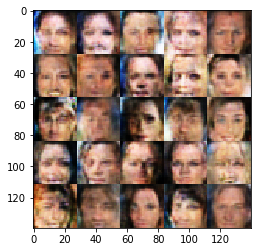

Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.8299... Generator Loss: 2.8825
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 2.7649
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 4.3179
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.6372


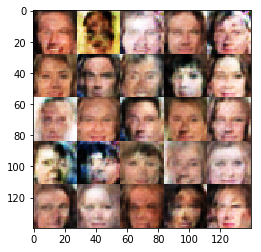

Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 2.1535
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0021


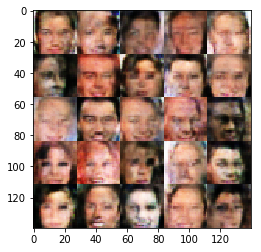

Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 2.0462
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 2.4296
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.2652


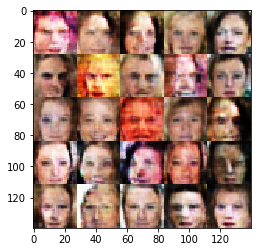

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6468


In [54]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.